In [1]:
# Importando as bibliotecas necessárias
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from google.colab import drive

import pathlib #provides classes for handling filesystem paths
import glob    #is used for Unix style pathname pattern expansion

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
root_base_path = '/content/drive/MyDrive/TopicosContemporaneos/ProjetoCNN/data'

In [6]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

## Leitura do Dataset usando o ImageFolder

O dataset escolhido foi de parreiras de uvas de 5 tipos diferentes.


url: https://www.muratkoklu.com/datasets/

nome: Grapevine Leaves Image Dataset

In [7]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_set_aug = datasets.ImageFolder(os.path.join(root_base_path, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(root_base_path, 'val'), transform=transform_no_aug)

train_loader_aug = DataLoader(train_set_aug, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

## Importando a resnet34

In [16]:
resnet34 = models.resnet34(weights="IMAGENET1K_V1")

In [17]:
resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# Congelar todas as camadas
for param in resnet34.parameters():
    param.requires_grad = False

In [19]:
# Substituir a última camada
resnet34.fc = nn.Linear(resnet34.fc.in_features, 5) # alterando de 1000 classes para 5 classes
resnet34 = resnet34.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet34.parameters(), lr=0.001, momentum=0.9)

In [22]:
# Treinando a resnet18
history = train_model(resnet34, train_loader_aug, val_loader, criterion, optimizer, device, num_epochs=10)

100%|██████████| 14/14 [04:02<00:00, 17.29s/it]


Epoch 1, Train Loss: 1.721, Train Accuracy: 21.88%
Epoch 1, Val Loss: 1.618, Val Accuracy: 26.67%


100%|██████████| 14/14 [01:20<00:00,  5.74s/it]


Epoch 2, Train Loss: 1.636, Train Accuracy: 25.18%
Epoch 2, Val Loss: 1.570, Val Accuracy: 26.67%


100%|██████████| 14/14 [01:20<00:00,  5.73s/it]


Epoch 3, Train Loss: 1.521, Train Accuracy: 32.24%
Epoch 3, Val Loss: 1.468, Val Accuracy: 32.00%


100%|██████████| 14/14 [01:20<00:00,  5.77s/it]


Epoch 4, Train Loss: 1.448, Train Accuracy: 38.12%
Epoch 4, Val Loss: 1.408, Val Accuracy: 41.33%


100%|██████████| 14/14 [01:19<00:00,  5.69s/it]


Epoch 5, Train Loss: 1.421, Train Accuracy: 36.71%
Epoch 5, Val Loss: 1.338, Val Accuracy: 42.67%


100%|██████████| 14/14 [01:20<00:00,  5.76s/it]


Epoch 6, Train Loss: 1.363, Train Accuracy: 45.41%
Epoch 6, Val Loss: 1.302, Val Accuracy: 41.33%


100%|██████████| 14/14 [01:20<00:00,  5.76s/it]


Epoch 7, Train Loss: 1.297, Train Accuracy: 48.71%
Epoch 7, Val Loss: 1.185, Val Accuracy: 58.67%


100%|██████████| 14/14 [01:20<00:00,  5.73s/it]


Epoch 8, Train Loss: 1.273, Train Accuracy: 48.94%
Epoch 8, Val Loss: 1.246, Val Accuracy: 57.33%


100%|██████████| 14/14 [01:20<00:00,  5.75s/it]


Epoch 9, Train Loss: 1.243, Train Accuracy: 52.71%
Epoch 9, Val Loss: 1.189, Val Accuracy: 61.33%


100%|██████████| 14/14 [01:19<00:00,  5.65s/it]


Epoch 10, Train Loss: 1.171, Train Accuracy: 59.29%
Epoch 10, Val Loss: 1.131, Val Accuracy: 65.33%
Treinamento concluído


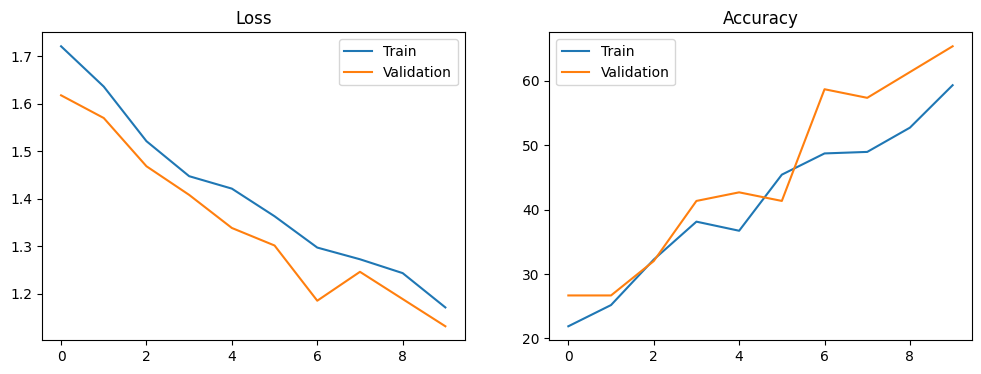

In [23]:
plot_history(history)

Acredito que, ao aumentar o número de épocas, o modelo poderia convergir para o ponto ótimo. Optou-se por não descongelar mais camadas devido ao fato de a rede ser muito grande e os dados limitados, o que dificultaria o cálculo dos pesos.

## Criando uma CNN do zero

5 camadas convolucional, 5 batch normalize e 6 lineares, uma rede com bastante camadas que demorou bastante no treinamento por causa do número de parametros.

In [24]:
class CNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)

        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(512 * 7 * 7, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2, padding=0)

        x = x.view(-1, 512 * 7 * 7)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)

        return x

model_CNN = CNN(num_classes=5).to(device)

images, labels = next(iter(train_loader_aug))
images = images.to(device) # Move images to GPU

model_CNN(images).shape

torch.Size([32, 5])

Houve uma alteração no optimizer para uma tentativa de melhora do modelo

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)

In [26]:
# Treinando a CNN
history_2 = train_model(model_CNN, train_loader_aug, val_loader, criterion, optimizer, device, num_epochs=10)

100%|██████████| 14/14 [01:52<00:00,  8.01s/it]


Epoch 1, Train Loss: 1.761, Train Accuracy: 18.12%
Epoch 1, Val Loss: 1.662, Val Accuracy: 20.00%


100%|██████████| 14/14 [01:57<00:00,  8.39s/it]


Epoch 2, Train Loss: 1.664, Train Accuracy: 17.41%
Epoch 2, Val Loss: 1.619, Val Accuracy: 20.00%


100%|██████████| 14/14 [01:52<00:00,  8.05s/it]


Epoch 3, Train Loss: 1.621, Train Accuracy: 18.12%
Epoch 3, Val Loss: 1.598, Val Accuracy: 20.00%


100%|██████████| 14/14 [01:52<00:00,  8.00s/it]


Epoch 4, Train Loss: 1.615, Train Accuracy: 18.35%
Epoch 4, Val Loss: 1.610, Val Accuracy: 20.00%


100%|██████████| 14/14 [01:52<00:00,  8.01s/it]


Epoch 5, Train Loss: 1.617, Train Accuracy: 21.41%
Epoch 5, Val Loss: 1.608, Val Accuracy: 20.00%


100%|██████████| 14/14 [01:53<00:00,  8.08s/it]


Epoch 6, Train Loss: 1.609, Train Accuracy: 20.71%
Epoch 6, Val Loss: 1.603, Val Accuracy: 38.67%


100%|██████████| 14/14 [02:01<00:00,  8.68s/it]


Epoch 7, Train Loss: 1.622, Train Accuracy: 16.00%
Epoch 7, Val Loss: 1.596, Val Accuracy: 20.00%


100%|██████████| 14/14 [01:53<00:00,  8.08s/it]


Epoch 8, Train Loss: 1.615, Train Accuracy: 18.35%
Epoch 8, Val Loss: 1.610, Val Accuracy: 20.00%


100%|██████████| 14/14 [01:53<00:00,  8.14s/it]


Epoch 9, Train Loss: 1.614, Train Accuracy: 21.88%
Epoch 9, Val Loss: 1.604, Val Accuracy: 20.00%


100%|██████████| 14/14 [01:54<00:00,  8.17s/it]


Epoch 10, Train Loss: 1.613, Train Accuracy: 20.24%
Epoch 10, Val Loss: 1.612, Val Accuracy: 36.00%
Treinamento concluído


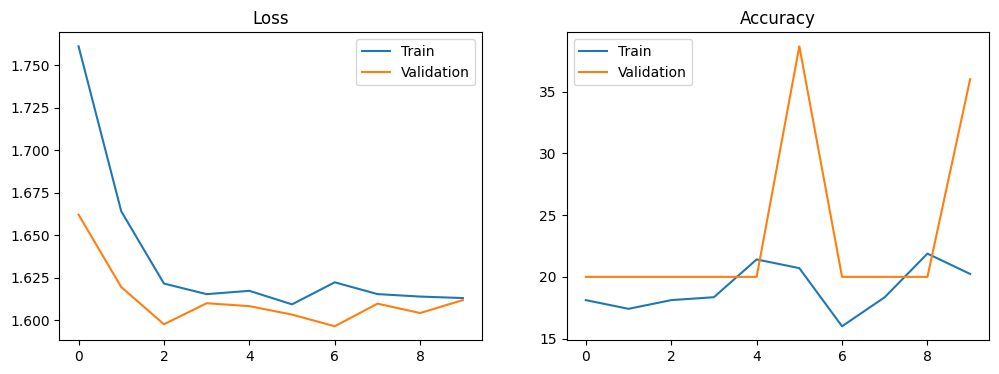

In [27]:
plot_history(history_2)

O dataset foi bem reduzido com apenas 500 amostras sendo 100 de cada categoria, isso fez com que o CNN não tivesse um desempenho muito bom.